In [5]:
import pandas as pd
import seaborn as sns
import numpy as np

In [6]:
anime_df = pd.read_csv('data/anime.csv')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [7]:
rating_df = pd.read_csv('data/rating.csv')
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [8]:
anime_df.shape

(12294, 7)

In [9]:
rating_df.shape

(7813737, 3)

In [10]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [11]:
def weighted_rating(v,m,R,C):
  return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )
def assign_popular_based_score(rating):
    filter_rating = rating_df[rating['rating'] != -1]
    vote_count = filter_rating.groupby('anime_id',as_index=False).agg({'user_id':'count', 'rating':'mean'})
    vote_count.columns = ['anime_id','vote_count', 'avg_rating']
    
    # calcuate input parameters
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 70)
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
    
    # post processing
    vote_count = vote_count.merge(anime_df[['anime_id','name']],on=['anime_id'],how='left')
    vote_count = vote_count.drop('anime_id', axis=1)
    popular_anime = vote_count.loc[:,['name', 'vote_count', 'avg_rating', 'weighted_rating']]
    
    return popular_anime

In [12]:
popular_anime = assign_popular_based_score(rating_df)

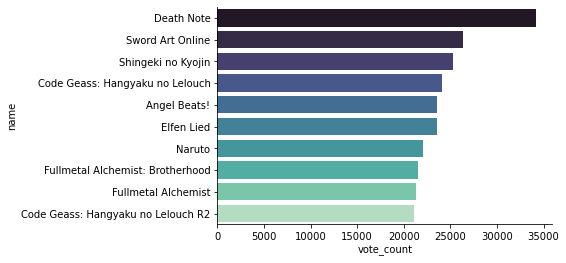

In [13]:
sns.barplot(data = popular_anime.sort_values('vote_count',ascending=False).head(10),
            x = 'vote_count', y = 'name', palette='mako');
sns.despine()

In [16]:
anime_index = pd.Series(anime_df.index, index=anime_df.name)
anime_index.head()

name
Kimi no Na wa.                      0
Fullmetal Alchemist: Brotherhood    1
Gintama°                            2
Steins;Gate                         3
Gintama&#039;                       4
dtype: int64

In [17]:
rating_df.loc[rating_df.rating == -1, 'rating'] = np.NaN
rating_df.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [18]:
joined = anime_df.merge(rating_df, how='inner', on='anime_id')
joined.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,NaN


In [19]:
m = joined['members'].quantile(0.80)
joined = joined[(joined['members'] >= m)]
joined = joined[(joined['user_id'] <= 10000)]
joined.shape

(209791, 9)

In [20]:
pivot = pd.pivot_table(joined, index='user_id', columns='name', values='rating_y')
pivot.dropna(axis=0, how='all', inplace=True)
pivot.head()

name,Accel World,Akame ga Kill!,Angel Beats!,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Another,Ansatsu Kyoushitsu (TV),Ao no Exorcist,Baccano!,Baka to Test to Shoukanjuu,Bakemonogatari,...,Sword Art Online II,Tengen Toppa Gurren Lagann,Toaru Majutsu no Index,Tokyo Ghoul,Tokyo Ghoul √A,Tonari no Kaibutsu-kun,Toradora!,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,Zankyou no Terror,Zero no Tsukaima
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,8.0,NaN,10.0,8.0,NaN,8.0,NaN,NaN,NaN,...,7.0,NaN,NaN,6.0,8.0,NaN,NaN,NaN,NaN,NaN
5,3.0,4.0,3.0,7.0,NaN,NaN,4.0,NaN,1.0,NaN,...,NaN,NaN,6.0,2.0,2.0,2.0,3.0,3.0,NaN,1.0
7,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
pivot.shape

(8967, 104)

In [22]:
pivot.fillna(0, inplace=True)
pivot.head()

name,Accel World,Akame ga Kill!,Angel Beats!,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Another,Ansatsu Kyoushitsu (TV),Ao no Exorcist,Baccano!,Baka to Test to Shoukanjuu,Bakemonogatari,...,Sword Art Online II,Tengen Toppa Gurren Lagann,Toaru Majutsu no Index,Tokyo Ghoul,Tokyo Ghoul √A,Tonari no Kaibutsu-kun,Toradora!,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,Zankyou no Terror,Zero no Tsukaima
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.0,8.0,0.0,10.0,8.0,0.0,8.0,0.0,0.0,0.0,...,7.0,0.0,0.0,6.0,8.0,0.0,0.0,0.0,0.0,0.0
5,3.0,4.0,3.0,7.0,0.0,0.0,4.0,0.0,1.0,0.0,...,0.0,0.0,6.0,2.0,2.0,2.0,3.0,3.0,0.0,1.0
7,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim_df = pd.DataFrame(cosine_similarity(pivot, pivot), index=pivot.index, columns=pivot.index)
user_sim_df.head()

user_id,1,2,3,5,7,8,9,10,11,12,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.181608,0.077850,0.157672,0.219578,0.000000,0.321019,0.131966,0.273179,...,0.000000,0.000000,0.000000,0.000000,0.166112,0.177187,0.000000,0.319874,0.134917,0.223814
2,0.000000,1.000000,0.209703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.111889,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.181608,0.209703,1.000000,0.476739,0.320707,0.142671,0.000000,0.316114,0.238462,0.328759,...,0.205496,0.265209,0.127955,0.368553,0.509828,0.378278,0.222424,0.275742,0.282385,0.235750
5,0.077850,0.000000,0.476739,1.000000,0.382446,0.148149,0.080904,0.014995,0.154873,0.207566,...,0.071666,0.136746,0.216077,0.274362,0.585380,0.452903,0.133485,0.158378,0.222931,0.084796
7,0.157672,0.000000,0.320707,0.382446,1.000000,0.150850,0.156055,0.151847,0.384006,0.304586,...,0.000000,0.000000,0.123834,0.201517,0.545027,0.422721,0.110347,0.280996,0.244445,0.114270


In [24]:
def get_similar_user(user_id):
    if user_id not in pivot.index:
        return None, None
    else:
        sim_users = user_sim_df.sort_values(by=user_id, ascending=False).index[1:]
        sim_score = user_sim_df.sort_values(by=user_id, ascending=False).loc[:, user_id].tolist()[1:]
        return sim_users, sim_score

In [25]:
users, score = get_similar_user(5)
for x,y in zip(users[:10], score[:10]):
    print("User {} with similarity of {}".format(x, y))

User 2300 with similarity of 0.6661479925813487
User 1963 with similarity of 0.6461246539067823
User 9122 with similarity of 0.6428932751587525
User 1842 with similarity of 0.6428559685031677
User 2342 with similarity of 0.6414000954295932
User 3275 with similarity of 0.6408771443981183
User 3990 with similarity of 0.6330169598476988
User 3739 with similarity of 0.6326654920043088
User 1176 with similarity of 0.630582074947154
User 3203 with similarity of 0.6303547875387372


In [31]:

def get_recommendation(user_id, n_anime=10):
    users, scores = get_similar_user(user_id)
    
    # there is no information for this user
    if users is None or score is None:
        return None
    
    # only take 10 nearest users
    user_arr = np.array([x for x in users[:10]])
    sim_arr = np.array([x for x in scores[:10]])
    predicted_rating = np.array([])
    
    for anime_name in pivot.columns:
        filtering = pivot[anime_name].loc[user_arr] != 0.0  
        temp = np.dot(pivot[anime_name].loc[user_arr[filtering]], sim_arr[filtering]) / np.sum(sim_arr[filtering])
        predicted_rating = np.append(predicted_rating, temp)
    
    # don't recommend something that user has already rated
    temp = pd.DataFrame({'predicted':predicted_rating, 'name':pivot.columns})
    filtering = (pivot.loc[user_id] == 0.0)
    temp = temp.loc[filtering.values].sort_values(by='predicted', ascending=False)
    return temp

    # recommend n_anime anime
    #recom=[]
    #recom.append(anime_df.loc[anime_index.loc[temp.name[:n_anime]]].name())
        
    #return anime_df.loc[anime_index.loc[temp.name[:n_anime]]].name()

In [36]:
df =get_recommendation(5)


In [50]:
df["name"].tolist()

NameError: name 'temp' is not defined

In [29]:
import pickle

In [22]:
pickle.dump(user_sim_df.to_dict(),open('user_sim_df','wb'))

In [24]:
pickle.dump(anime_index.to_dict(),open('anime_index','wb'))

In [30]:
pickle.dump(pivot.to_dict(),open('pivot','wb'))